# Problem Description
The goal of this project is to predict whether a given tweet is about a real disaster or not. "For each ID in the test set, you must predict 1 if the tweet is describing a real disaster, and 0 otherwise." - Submission File section of the NLP disaster tweets project overview page on Kaggle.

# Data
- id: a unique identifier for each tweet
- text: the text of the tweet
- location: the location the tweet was sent from (may be blank)
- keyword: a particular keyword from the tweet (may be blank)
- target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# NLP description 
NLP (natural language processing) is a type of machine learning that allows computers to interpret text data.  "A technology that uses machine learning algorithms to interpret human language and analyze data. NLP can be used to automate legal discovery, organize information, and speed up reviews. It can also be used to improve the user experience for voice assistants and generative AI chatbots." - Gemeni Output for the following prompt: "nlp".pt: "nlp".ext data.  

# Project Setup

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

warnings.filterwarnings("ignore", category=FutureWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')       

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Exploratory Data Analysis
Here I looked at the basic structure of the data and looked for any missing values.  I plotted the target variable distribution as well as the word count distribution.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Missing Values:
           Count  Perce

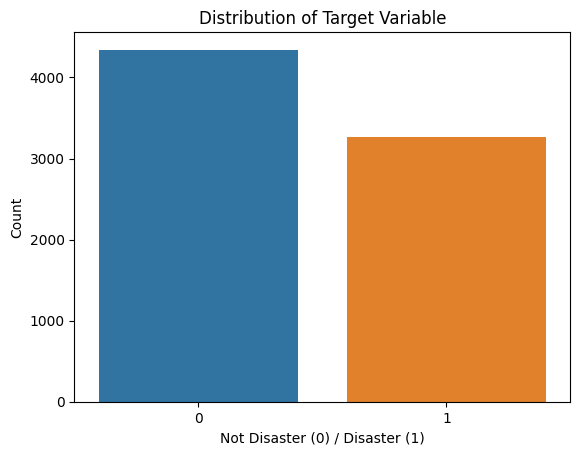

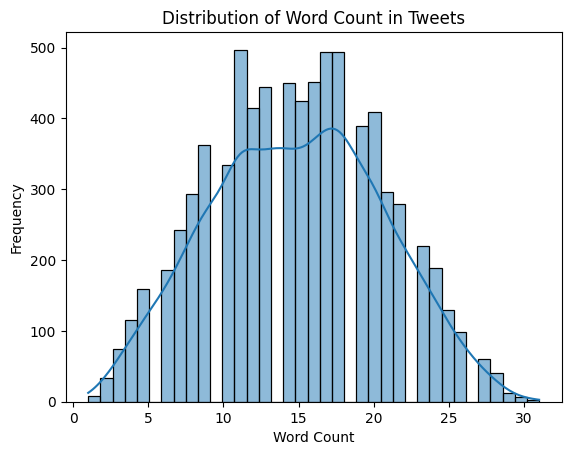

In [2]:
train_data.info()
print('')
print(train_data.head())

# Missing values count
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100
print("\nMissing Values:\n", pd.DataFrame({"Count": missing_values, "Percentage": missing_percentage}))

# Target distribution
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Not Disaster (0) / Disaster (1)')
plt.ylabel('Count')
plt.show()

# Word count distribution
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(train_data['word_count'], kde=True)
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Plan of Analysis 
Looking at the distribution of the target variable, it seems that it is relatively-evenly balanced.  This will allow for standard classification modeling without adjustments for class imbalance.  The following code will precede the modeling phase. I will be applying tolkenization (splitting text into units), removing stop words (excluding any words that are common and provide little information), sequencing and padding (ordering words and ensuring common lengths), and splitting the data into train and test sets (validation).  I then will be training it using an LSTM (Long-Short Term Memory Recurrent Neural Network). 

# Data Cleaning/Preprocessing
Here I removed stop words and split out the features from the target variable.  I initilized an out-of-vocabulary tolkenizer for unseen words.  I transformed the text into a sequence of numbers based off the tolkenizer index. I padded the text with zeroes on the end of shorter sequences ('post' argument). I then split out the training data from the test data. 

In [3]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# separate features and remove stop words
X = train_data['text'].apply(lambda x: remove_stopwords(str(x))).values
y = train_data['target'].values

vocab_size = 10000
embedding_dim = 64

# tolkenizer init
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# sequence and pad
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, padding='post')

# split data
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Model Architecture
- Model structure and compilation
- Instantiate callbacks
- Train the model
- Hyper parameter tuning for the number of LSTM Units

In [7]:
results = []

for units in [32, 64, 128]:
  print(f"Training model with {units} LSTM units...")

  model = Sequential([
      Embedding(vocab_size, embedding_dim),
      LSTM(units, dropout=0.2, recurrent_dropout=0.2),
      Dense(32, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  early_stopping = EarlyStopping(
      monitor='val_accuracy', 
      patience=3,  
      restore_best_weights=True 
  )

  model_checkpoint = ModelCheckpoint(
      'best_model.keras',  
      monitor='val_loss',
      save_best_only=True,  
      mode='min' 
  )

  history = model.fit(
      X_train, y_train,
      validation_data=(X_val, y_val),
      epochs=50,
      batch_size=64,
      verbose=2,
      callbacks=[early_stopping, model_checkpoint]
  )
  best_val_accuracy = max(history.history['val_accuracy'])
  best_val_loss = min(history.history['val_loss'])
  results.append({'LSTM Units': units, 
                  'Best Val Accuracy': best_val_accuracy, 
                  'Best Val Loss': best_val_loss})

results_df = pd.DataFrame(results)
print("\nSummary of Hyperparameter Search Results:")
print(results_df)

print(f"\nModel with {units} LSTM units achieved best validation accuracy: {best_val_accuracy:.4f}")
print(f"Model with {units} LSTM units achieved best validation loss: {best_val_loss:.4f}")

print('\nTraining Complete')

Training model with 32 LSTM units...
Epoch 1/50
96/96 - 7s - 76ms/step - accuracy: 0.5683 - loss: 0.6835 - val_accuracy: 0.5962 - val_loss: 0.6539
Epoch 2/50
96/96 - 4s - 46ms/step - accuracy: 0.7677 - loss: 0.5274 - val_accuracy: 0.7820 - val_loss: 0.4693
Epoch 3/50
96/96 - 4s - 46ms/step - accuracy: 0.8627 - loss: 0.3874 - val_accuracy: 0.8050 - val_loss: 0.4617
Epoch 4/50
96/96 - 4s - 46ms/step - accuracy: 0.9000 - loss: 0.3116 - val_accuracy: 0.7958 - val_loss: 0.4934
Epoch 5/50
96/96 - 5s - 48ms/step - accuracy: 0.9202 - loss: 0.2596 - val_accuracy: 0.7879 - val_loss: 0.5456
Epoch 6/50
96/96 - 4s - 46ms/step - accuracy: 0.9355 - loss: 0.2324 - val_accuracy: 0.7814 - val_loss: 0.6135
Training model with 64 LSTM units...
Epoch 1/50
96/96 - 6s - 67ms/step - accuracy: 0.6378 - loss: 0.6326 - val_accuracy: 0.7833 - val_loss: 0.5165
Epoch 2/50
96/96 - 4s - 42ms/step - accuracy: 0.8433 - loss: 0.4176 - val_accuracy: 0.7899 - val_loss: 0.4737
Epoch 3/50
96/96 - 4s - 43ms/step - accuracy: 

# Results and Analysis The final model achieved the following metrics on the validation set:

- Validation Accuracy: 0.80
- Precision (Non-Disaster): 0.80
- Recall (Non-Disaster): 0.88
- F1-Score (Non-Disaster): 0.83
- Precision (Disaster): 0.81
- Recall (Disaster): 0.69
- F1-Score (Disaster): 0.75.
### Hyperparameter Tuning Process

| **LSTM Units** | **Best Val Accuracy** | **Best Val Loss** |
|----------------|-----------------------|-------------------|
| 32             | 0.8049               | 0.4617           |
| 64             | 0.8004               | 0.4673           |
| 128            | 0.8004               | 0.4619           |


# Conclusion
The model had generally good performance. The model identifies negative cases correctly. The model generally did well with the postitives but missed more than the negative class.  This could be an issue in the usefulness of the model where detecting disaster tweets may be a bigger priority than limiting false positives. Something that could be done is to tune the model for better recall if the priority is detecting positive cases.  Hyperparameter tuning and layer engineering could be an area to improve on and increase the score further.  Preprocessing the data further with techniques like lemmatization or stemming might be helpful as w

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7933 - loss: 0.5365
Validation Accuracy: 0.80
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



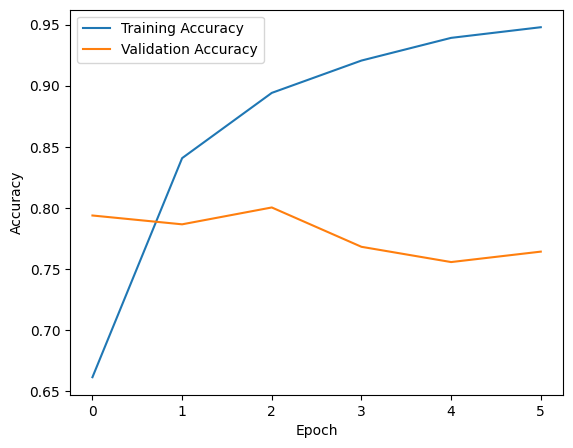

In [8]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy:.2f}')

y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred, zero_division=1))


# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Submission

In [6]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
X_test = test_data['text'].values

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, padding='post')

predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
